In [5]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))

from config import *
from ssqa import *
from ss_inference import *
from data import *

DATA = PFAM_DATA
DATASET = "mutfromeccm"
warnings.filterwarnings("ignore")

## PFAM sequence extraction

In [6]:
data = torch.load(f"{DATA}/{DATASET}/data.pt")

In [10]:
pfam_data(f"{DATA}/{DATASET}", "full.fasta")
structfam = get_structures(DATA, DATASET)
build_patterns(structfam, f"{DATA}/{DATASET}")

building sequences.csv
building data.pt
building aligned.fasta, unaligned.fasta ...
building clusters with MMSEQS
computing cluster weights
split between training and validation set
make HMM profile
build HMM profiles


0it [00:00, ?it/s]

No pattern find


(None, None, None, None)

In [79]:
if "1" in STEPS:
    extract_data(f"{DATA}/{DATASET}", "full.fasta")

if "2" in STEPS:
    structfam = get_structures(DATA, DATASET)
    pfam_seqs = pd.read_csv(f"{DATA}/{DATASET}/sequences.csv", index_col = 0, usecols = [0,2]).seq
    pfam_seqs = {k.split("/")[0]:v for k,v in pfam_seqs.items()}
    patterns, secondary_structure, c_patterns, n_patterns = build_patterns(pfam_seqs, structfam)

if "3" in STEPS:
    dataset = SecondaryStructureRawDataset(f"{DATA}/{DATASET}/hmm.pkl", 20)
    loader = DataLoader(dataset, batch_size = 1,
                            shuffle=False, drop_last=False, collate_fn = collate_sequences)

    device = "cuda"

    model_ss3 = NetSurfP2(20)
    model_ss3 = model_ss3.to(device)
    model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_20feats.h5"))

    others, ss8, ss3 = model_ss3.predict(loader)
    pickle.dump(ss3, open(f"{DATA}/{DATASET}/ss3.pkl", "wb"))
    pickle.dump(ss8, open(f"{DATA}/{DATASET}/ss8.pkl", "wb"))
    pickle.dump(others, open(f"{DATA}/{DATASET}/others.pkl", "wb"))


0it [00:00, ?it/s]
33273it [10:51, 51.11it/s]


In [57]:
dataset = SSQAData(f"{DATA}/{DATASET}/data.pt")
loader = DataLoader(dataset, batch_size = 16,
                        shuffle=False, drop_last=False, collate_fn = collate_sequences)
device = "cuda"

model_ss3 = NetSurfP2(50, "nsp")
model_ss3 = model_ss3.to(device)
model_ss3.load_state_dict(torch.load(f"{UTILS}/lstm_50feats.h5"))
others, ss8, ss3 = model_ss3.predict(loader)


Available :  seq L cluster_index weights subset seq_hmm pattern


3593it [01:11, 50.34it/s]


In [80]:
pfam_aligned_seqs = pd.read_csv(f"{DATA}/{DATASET}/sequences.csv", index_col = 0, usecols = [0,1]).aligned_seq
pfam_aligned_seqs = {k:np.array([int(i in AA) for i in v]) for i,(k,v) in enumerate(pfam_aligned_seqs.items())}

In [65]:
ss3 = pickle.load(open(f"{DATA}/{DATASET}/ss3.pkl", "rb"))

In [81]:
aligned_ss3 = torch.zeros((len(ss3), 3, 100*(N//100+1)))

for i, (k, s) in enumerate(zip(pfam_aligned_seqs.keys(), ss3)):
    idx = np.where(pfam_aligned_seqs[k] > 0)[0]
    aligned_ss3[i, :,idx] = s

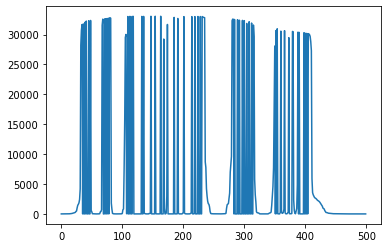

In [75]:
plt.plot(aligned_ss3.sum(0).sum(0))


extended mean profile



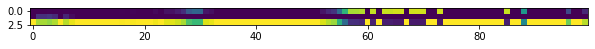

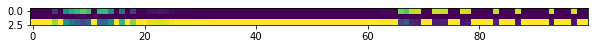

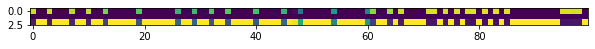

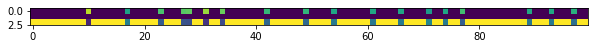

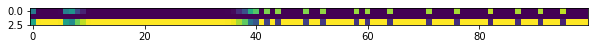

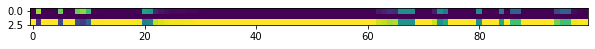

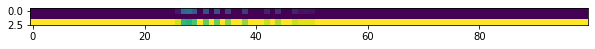

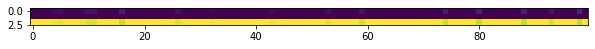

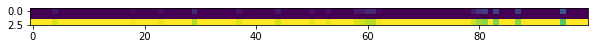

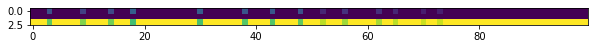

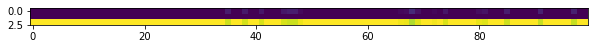

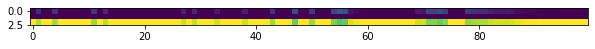

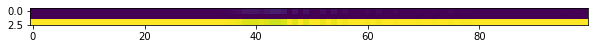

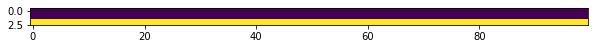

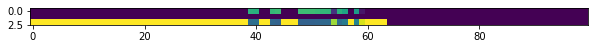


extended argmax profile



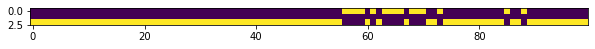

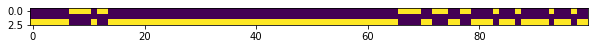

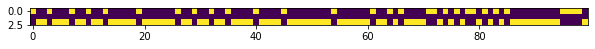

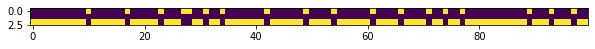

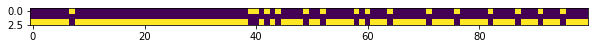

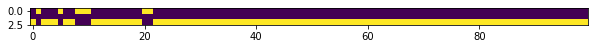

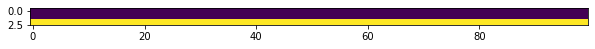

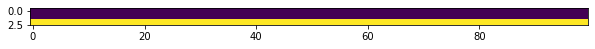

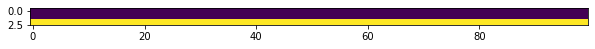

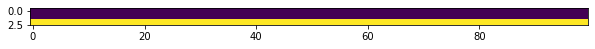

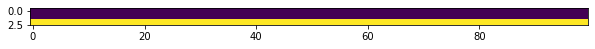

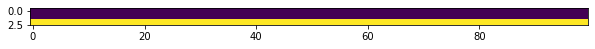

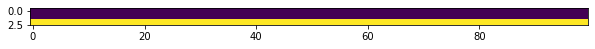

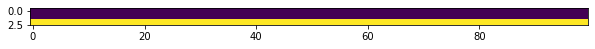

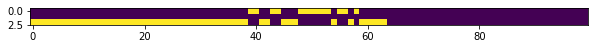

In [20]:
onehot_ss3 = torch.zeros(*aligned_ss3.size())
for i, x in enumerate(aligned_ss3):
    onehot_ss3[i] = torch.tensor(to_onehot(x.argmax(0), (None,3)).T)
    
hotpoints3 = onehot_ss3.sum(0)

print(), print("extended mean profile"), print()
x = (1+hotpoints3)/(1+hotpoints3).sum(0)
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 
    
print(), print("extended argmax profile"), print()
x = to_onehot(hotpoints3.argmax(0), (None,3)).T
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 


extended mean profile



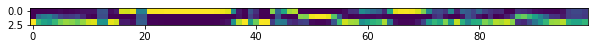

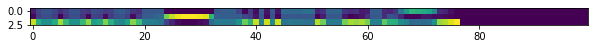


extended mean profile



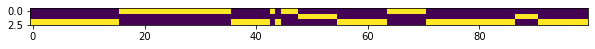

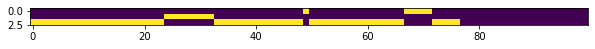

In [56]:
hotpoints4 = (hotpoints3 + hotpoints2[:,:200])/2

print(), print("extended mean profile"), print()
x = (1+hotpoints4)/(1+hotpoints4).sum(0)
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 
    
print(), print("extended mean profile"), print()
x = to_onehot(hotpoints4.argmax(0), (None,3)).T
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 

In [36]:
sse = to_onehot(hotpoints2[:,:N].argmax(0), (None,3))
ss = np.pad(sse, ((1,1),(0,0)), "constant")
dss = (ss[1:] - ss[:-1])
cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
pat = np.argmax(bbox[:,2:],1)

c_patterns, n_patterns = [],[]
char_pat= "".join(["abc"[x] for x in pat])
if len(char_pat) and char_pat not in c_patterns:
    c_patterns.append(char_pat)
    n_patterns.append(list(pat))

In [41]:
c_patterns

['cacacacacbcacacbcbcacbcacacacbcbcacbcacbacacbcbcacacacacacbcacbcbacacaca']

In [61]:
ss_profile = np.log(hotpoints3[:,:N]).T

In [70]:
ss_profile = (1+hotpoints3[:,:N])/(1+hotpoints3[:,:N]).sum(0).T

In [38]:
ss_profile = np.log(hotpoints2[:,:N]).T
ss_profile.shape

(1464, 3)

In [39]:
pickle.dump(ss_profile, open(f"{DATA}/{DATASET}/ss_profile.pkl", "wb"))
pickle.dump((n_patterns, c_patterns, list(patterns.keys())), open(f"{DATA}/{DATASET}/patterns.pkl", "wb"))

## Vizualization

In [27]:
from structure.graphics import visualize_secondary_structure
from structure.data_extraction import fetch_PDB
import matplotlib.pyplot as plt

5VZL


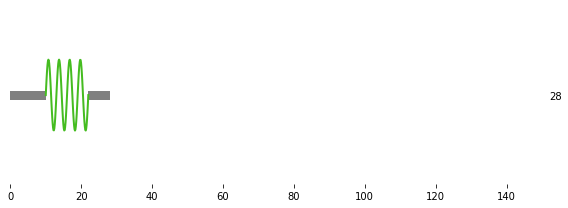

6K4S


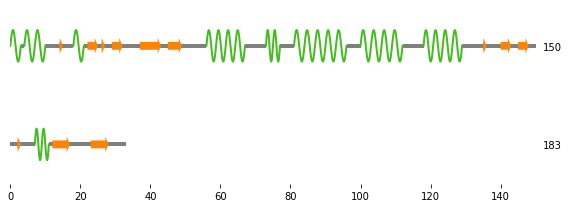

5XBL


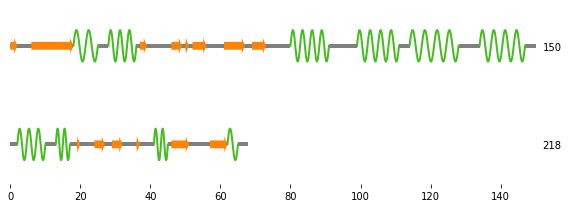

6MCB


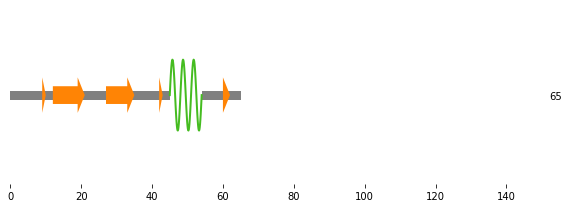

6MCC


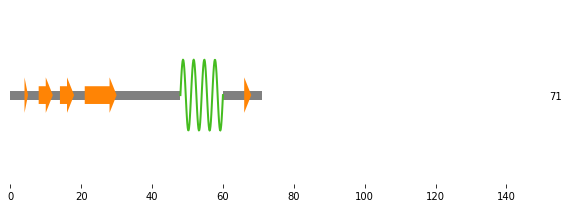

In [28]:
for pdb, pfam, c, start, end in structfam.values():
    try:
        print(pdb)
        sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
        visualize_secondary_structure(sse, 0, 150)
        plt.show()
    except:
        print(pdb, pfam, c, start, end+1)

In [6]:
fetch_PDB('1YIU', 'A', 6, 35)

(array(['c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c',
        'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c',
        'c', 'c', 'c'], dtype='<U1'),
 <biotite.structure.AtomArray at 0x7f2e04c0a310>)

In [1]:
from biotite.structure.io.pdb import get_structure

In [2]:
get_structure('1YIU', 'A', 6, 35)

AttributeError: 'str' object has no attribute 'get_structure'